<a href="https://colab.research.google.com/github/mrathode/Sign_Language_Recognition/blob/master/SLR_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.utils import np_utils, plot_model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train_data = pd.read_csv('/content/drive/My Drive/Project/sign-language-mnist/sign_mnist_train.csv')
test_data = pd.read_csv('/content/drive/My Drive/Project/sign-language-mnist/sign_mnist_test.csv')

In [0]:
data = pd.concat([train_data, test_data])
print(data.shape)

(34627, 785)


In [0]:
data.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


In [0]:
X_train = data.iloc[:, 1:]
y_train = data.iloc[:, 0]


display(X_train.info())
# display(y_train.dtype)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 34627 entries, 0 to 7171
Columns: 784 entries, pixel1 to pixel784
dtypes: int64(784)
memory usage: 207.4 MB


None

In [0]:
X_train = np.array(X_train.iloc[:, :], dtype='uint8')
X_train = np.array([np.reshape(i, (28, 28)) for i in X_train])


num_classes = 26

y_train = np.array(y_train, dtype='int8').reshape(-1)


y_train = np.eye(num_classes)[y_train]


X_train = X_train.reshape((34627, 28, 28, 1))


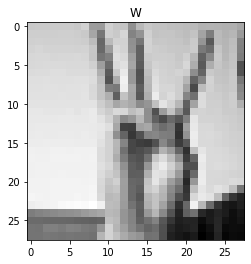

In [0]:
idx = np.random.randint(0, 34628, 1)
plt.title(chr(y_train[idx].argmax() + 65))
plt.imshow(X_train[idx].reshape(28,28), cmap='gray')

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state = 42)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(25970, 28, 28, 1)

(8657, 28, 28, 1)

(25970, 26)

(8657, 26)

In [0]:
def cnn_model():
    model = Sequential()

    model.add(Conv2D(filters=8, kernel_size=(2, 2), strides=(1, 1), padding='same', input_shape=(28,28,1), activation='relu', data_format='channels_last'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Conv2D(filters=16, kernel_size=(4, 4), strides=(1, 1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(26, activation='softmax'))

    # sgd = SGD(lr=0.001)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
# model

In [0]:
model = cnn_model()
model.summary()
# plot_model(model, to_file='cnn_model.png', show_shapes=True)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 8)         40        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 16)        1168      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 4, 4, 16)          4112      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 1, 1, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 16)               

In [0]:
#set early stopping criteria
pat = 5 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('SLR_CNN_1.h5', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=20, BATCH_SIZE=128):
#     model = None
    model = cnn_model()
    results = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping,model_checkpoint])  
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results

In [0]:
# K-Fold cross validation
n_folds = 5
epochs = 20
batch_size = 128

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(X_train, y_train, test_size=0.2, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Train on 25970 samples, validate on 8657 samples
Epoch 1/20
25970/25970 [==============================] - 3s 100us/step - loss: 2.4988 - acc: 0.3047 - val_loss: 1.2276 - val_acc: 0.5980

Epoch 00001: val_loss did not improve from 0.00276
Epoch 2/20
25970/25970 [==============================] - 1s 50us/step - loss: 0.8602 - acc: 0.7077 - val_loss: 0.5838 - val_acc: 0.8046

Epoch 00002: val_loss did not improve from 0.00276
Epoch 3/20
25970/25970 [==============================] - 1s 53us/step - loss: 0.4336 - acc: 0.8513 - val_loss: 0.3032 - val_acc: 0.9008

Epoch 00003: val_loss did not improve from 0.00276
Epoch 4/20
25970/25970 [==============================] - 1s 47us/step - loss: 0.2428 - acc: 0.9208 - val_loss: 0.2290 - val_acc: 0.9286

Epoch 00004: val_loss did not improve from 0.00276
Epoch 5/20
25970/25970 [==============================] - 1s 47us/step - loss: 0.1458 - acc: 0.9548 - val_loss: 0.0961 - val_acc: 0.9761

Epoch 00005: val_loss did not impro

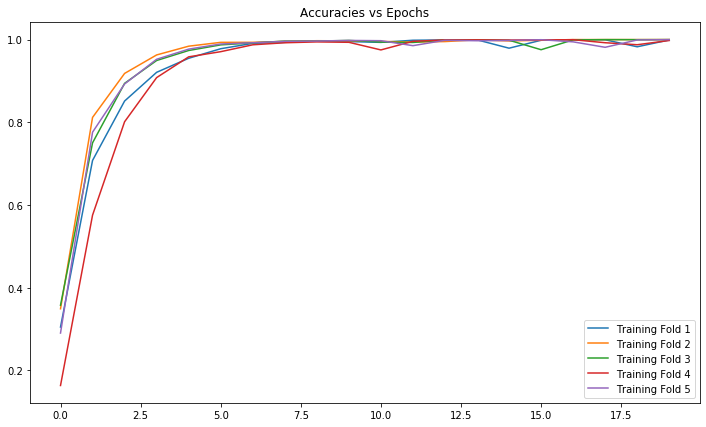

In [0]:
plt.rcParams['figure.figsize'] = [12, 7]
plt.title('Accuracies vs Epochs')
for i in range(n_folds):
  plt.plot(model_history[i].history['acc'], label=f'Training Fold {i+1}')

plt.legend()
plt.show()

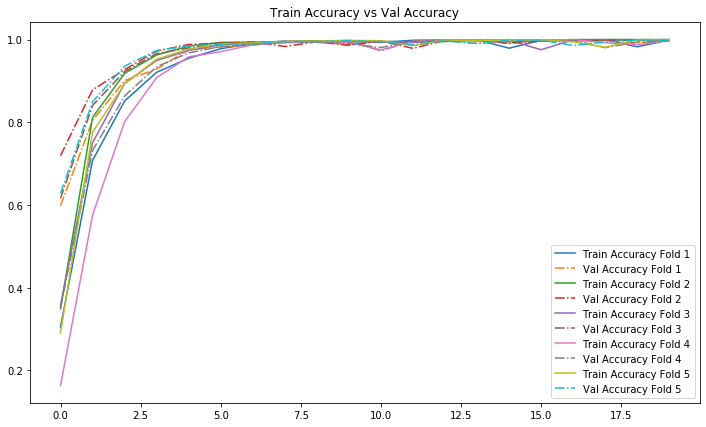

In [0]:
plt.title('Train Accuracy vs Val Accuracy')
for i in range(n_folds):
  plt.plot(model_history[i].history['acc'], label=f'Train Accuracy Fold {i+1}')
  plt.plot(model_history[i].history['val_acc'], label=f'Val Accuracy Fold {i+1}', linestyle = "dashdot")
plt.legend()
plt.show()

In [0]:
# true_labels_df = pd.DataFrame(y_test)
# true_labels = true_labels_df.idxmax(axis=1)
# true_labels

# predictions = model.predict(X_test)
# preds_df = pd.DataFrame(predictions)
# predicted_labels = preds_df.idxmax(axis=1)

# print(classification_report(true_labels, predicted_labels, labels=np.unique(predicted_labels)))

In [0]:
# def draw_confusion_matrix(true,preds):
#     conf_matx = confusion_matrix(true, preds)
#     sns.heatmap(conf_matx, annot=True, annot_kws={"size": 12}, fmt='g', cbar=False, cmap="viridis")
#     plt.show()

In [0]:
# confusion_matrix(true_labels, predicted_labels)